# Cleaning Data and Splitting into Test/Train Split

## Cleaning the Data

### Importing packages and data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [15]:
#Importing data from csv's
traffic = pd.read_csv('csvs/reduced-Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Segment_-_2011-2018_20240329.csv')
weather = pd.read_csv('csvs/weather-chicago, il 2018-04-01 to 2018-05-01.csv')
crashes = pd.read_csv("csvs/Traffic_Crashes_-_Crashes_20240329.csv")
segments = pd.read_csv("csvs/segments_dict.csv")

### Merging traffic and weather data

In [16]:
# These functions turn the timestamp in the traffic dataset into the nearst time stamp
# of the weather dataset (in that weather dataset's format), for merging
def traffic_time_to_weather_time(instr):
    date = instr.split()[0]
    #print(date)
    time = instr.split()[1]
    ampm = instr.split()[2]
    
    year = date.split("/")[2]
    month = date.split("/")[0]
    day = date.split("/")[1]
    
    hour = time.split(":")[0] if ampm == "AM" else str(int(time.split(":")[0])+12)
    
    return (year+"-"+month+"-"+day+"T"+hour+":00:00")
def make_new_time(row):
    return traffic_time_to_weather_time(row["TIME"])

In [17]:
traffic["datetime"] = traffic.apply(make_new_time, axis=1)
traffic

,TIME,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED,datetime
0,04/30/2018 11:50:28 PM,1133,1,5,27,2018-04-30T23:00:00
1,04/30/2018 11:50:28 PM,1133,1,5,27,2018-04-30T23:00:00
2,04/30/2018 11:50:28 PM,1153,1,4,23,2018-04-30T23:00:00
3,04/30/2018 11:50:28 PM,1153,1,4,23,2018-04-30T23:00:00
4,04/30/2018 11:50:28 PM,1178,1,5,16,2018-04-30T23:00:00
...,...,...,...,...,...,...
2577596,04/01/2018 12:01:06 AM,203,1,12,18,2018-04-01T12:00:00
2577597,04/01/2018 12:01:06 AM,204,1,1,24,2018-04-01T12:00:00
2577598,04/01/2018 12:01:06 AM,205,1,7,24,2018-04-01T12:00:00
2577599,04/01/2018 12:01:06 AM,206,1,6,24,2018-04-01T12:00:00


In [18]:
# New merged dataset 
traffic_merged = traffic.merge(weather, how='left')
traffic_merged.columns

Index(['TIME', 'SEGMENTID', 'BUS COUNT                ', 'MESSAGE COUNT',
       'SPEED', 'datetime', 'name', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')

### Remove Null Rows

Observe below that most of the weather-related columns have exactly 126557 null-valued entries, indicating that they might all be the same rows. We remove all the rows with just one of these features (`temp`), and we observe that all null values except for those in 2 columns (which we indend to drop anyway) go away, meaning these are points that should be removed anyway 

In [19]:
print(traffic_merged.isnull().sum())

TIME                               0
SEGMENTID                          0
BUS COUNT                          0
MESSAGE COUNT                      0
SPEED                              0
datetime                           0
name                          126557
temp                          126557
feelslike                     126557
dew                           126557
humidity                      126557
precip                        126557
precipprob                    126557
preciptype                   2306808
snow                          126557
snowdepth                     126557
windgust                      126557
windspeed                     126557
winddir                       126557
sealevelpressure              126557
cloudcover                    126557
visibility                    126557
solarradiation                126557
solarenergy                   126557
uvindex                       126557
severerisk                   2577601
conditions                    126557
i

In [20]:
traffic_merged = traffic_merged.loc[traffic_merged["temp"].isnull()==False]

In [21]:
print(traffic_merged.isnull().sum())

TIME                               0
SEGMENTID                          0
BUS COUNT                          0
MESSAGE COUNT                      0
SPEED                              0
datetime                           0
name                               0
temp                               0
feelslike                          0
dew                                0
humidity                           0
precip                             0
precipprob                         0
preciptype                   2180251
snow                               0
snowdepth                          0
windgust                           0
windspeed                          0
winddir                            0
sealevelpressure                   0
cloudcover                         0
visibility                         0
solarradiation                     0
solarenergy                        0
uvindex                            0
severerisk                   2451044
conditions                         0
i

### Dropping columns we won't end up using

In [22]:
traffic_merged = traffic_merged.drop(['BUS COUNT                ', 'MESSAGE COUNT', 'datetime', 'name', 'precipprob', 
               'snow', 'windspeed', 'winddir', 'severerisk', 'icon', 'stations', 'preciptype'], axis=1)

The below code is a checker for null values. By not raising an error and not outputting anything, we confirm that we have no null values 

In [23]:
for column in traffic_merged.columns:
    if traffic_merged[column].isnull().any():
        # If NaN values are found, raise an exception
        raise Exception(f"NaN values found in column {column}")

### Sorting values by time

In [24]:
def make_std_time(row):
    return datetime.strptime(row["TIME"], '%m/%d/%Y %I:%M:%S %p')
traffic_merged["std_datetime"] = traffic.apply(make_std_time, axis=1)
traffic_merged

,TIME,SEGMENTID,SPEED,temp,feelslike,dew,humidity,precip,snowdepth,windgust,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,std_datetime
0,04/30/2018 11:50:28 PM,1133,27,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
1,04/30/2018 11:50:28 PM,1133,27,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
2,04/30/2018 11:50:28 PM,1153,23,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
3,04/30/2018 11:50:28 PM,1153,23,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
4,04/30/2018 11:50:28 PM,1178,16,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577596,04/01/2018 12:01:06 AM,203,18,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577597,04/01/2018 12:01:06 AM,204,24,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577598,04/01/2018 12:01:06 AM,205,24,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577599,04/01/2018 12:01:06 AM,206,24,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06


In [25]:
traffic_merged = traffic_merged.sort_values(by=['std_datetime','SEGMENTID'])

In [26]:
traffic_merged.ffill().bfill()

,TIME,SEGMENTID,SPEED,temp,feelslike,dew,humidity,precip,snowdepth,windgust,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,std_datetime
2577550,04/01/2018 12:01:06 AM,1,25,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577551,04/01/2018 12:01:06 AM,2,20,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577552,04/01/2018 12:01:06 AM,7,32,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577553,04/01/2018 12:01:06 AM,8,27,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577554,04/01/2018 12:01:06 AM,9,28,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,04/30/2018 11:50:28 PM,1305,20,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
80,04/30/2018 11:50:28 PM,1307,25,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
81,04/30/2018 11:50:28 PM,1307,25,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
82,04/30/2018 11:50:28 PM,1309,29,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28


In [27]:
for column in traffic_merged.columns:
    nan_count_before = traffic_merged[column].isnull().sum()
    if nan_count_before > 0:
        print(f"Processing column: {column}")

        traffic_merged[column] = traffic_merged[column].ffill().bfill()

        most_common_value = traffic_merged[column].mode()[0]

        nan_count_after = traffic_merged[column].isnull().sum()
        if nan_count_after > 0:
            traffic_merged[column].fillna(most_common_value, inplace=True)

        if traffic_merged[column].isnull().any():
            raise Exception(f"NaN values still present in {column} after filling!")

        unique_values = traffic_merged[column].unique()[:10]
        nan_filled = nan_count_before - nan_count_after

        print(f"Used '{most_common_value}' to fill {nan_filled} NaNs in {column}")
        print(f"First 10 unique values in {column} after filling NaNs: {unique_values}\n")

### Adding weekday and time of day columns 

In [28]:
def add_weekday(row):
    cur_time = row["std_datetime"]
    return cur_time.weekday()
def add_time(row):
    cur_time = row["std_datetime"]
    return (cur_time.hour*3600)+(cur_time.minute*60)+(cur_time.second)

In [29]:
traffic_merged["weekday"]=traffic_merged.apply(add_weekday, axis=1)
traffic_merged["time_of_day"]=traffic_merged.apply(add_time, axis=1)

In [30]:
segments_dict = {}
for i in segments.iterrows():
    #print(i[1]["SEGMENTID"])
    long = (i[1]["START_LONGITUDE"] + i[1]["END_LONGITUDE"])/2
    lat = (i[1][" START_LATITUDE"] + i[1][" END_LATITUDE"])/2
    segments_dict[i[1]["SEGMENTID"]] = (lat, long)

In [31]:
def add_lat(row):
    return segments_dict[row["SEGMENTID"]][0]
def add_long(row):
    return segments_dict[row["SEGMENTID"]][1]

In [32]:
traffic_merged["lat"] = traffic_merged.apply(add_lat, axis=1)
traffic_merged["long"] = traffic_merged.apply(add_long, axis=1)

### One-hot encoding conditions (the only categorical variable)

In [33]:
def is_clear(row):
    return 1 if row["conditions"]=="Clear" else 0
def is_overcast(row):
    return 1 if row["conditions"]=="Overcast" else 0
def is_partcloud(row):
    return 1 if row["conditions"]=="Partially cloudy" else 0
def is_rainovercase(row):
    return 1 if row["conditions"]=="Rain, Overcast" else 0
def is_snowovercast(row):
    return 1 if row["conditions"]=="Snow, Overcast" else 0
def is_snowrainovercast(row):
    return 1 if row["conditions"]=="Snow, Rain, Overcast" else 0

In [34]:
traffic_merged["is_clear"] = traffic_merged.apply(is_clear, axis=1)
traffic_merged["is_overcast"] = traffic_merged.apply(is_overcast, axis=1)
traffic_merged["is_partcloud"] = traffic_merged.apply(is_partcloud, axis=1)
traffic_merged["is_rainovercase"] = traffic_merged.apply(is_rainovercase, axis=1)
traffic_merged["is_snowovercast"] = traffic_merged.apply(is_snowovercast, axis=1)
traffic_merged["is_snowrainovercast"] = traffic_merged.apply(is_snowrainovercast, axis=1)

In [35]:
traffic_merged[["conditions", "is_clear","is_overcast","is_partcloud", "is_rainovercase", "is_snowovercast", "is_snowrainovercast"]].sample(10)

,conditions,is_clear,is_overcast,is_partcloud,is_rainovercase,is_snowovercast,is_snowrainovercast
972923,Clear,1,0,0,0,0,0
2431076,Partially cloudy,0,0,1,0,0,0
1496692,Partially cloudy,0,0,1,0,0,0
305171,Partially cloudy,0,0,1,0,0,0
2354416,"Rain, Overcast",0,0,0,1,0,0
1426904,Overcast,0,1,0,0,0,0
1880580,Overcast,0,1,0,0,0,0
1000921,Clear,1,0,0,0,0,0
2300796,"Snow, Overcast",0,0,0,0,1,0
1843471,"Snow, Rain, Overcast",0,0,0,0,0,1


In [36]:
traffic_merged.columns

Index(['TIME', 'SEGMENTID', 'SPEED', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'snowdepth', 'windgust', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'conditions',
       'std_datetime', 'weekday', 'time_of_day', 'lat', 'long', 'is_clear',
       'is_overcast', 'is_partcloud', 'is_rainovercase', 'is_snowovercast',
       'is_snowrainovercast'],
      dtype='object')

In [37]:
traffic_merged = traffic_merged.drop(["SEGMENTID", "conditions", "std_datetime", "TIME"], axis=1)
traffic_merged

,SPEED,temp,feelslike,dew,humidity,precip,snowdepth,windgust,sealevelpressure,cloudcover,...,weekday,time_of_day,lat,long,is_clear,is_overcast,is_partcloud,is_rainovercase,is_snowovercast,is_snowrainovercast
2577550,25,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,...,6,66,41.793104,-87.718384,0,0,1,0,0,0
2577551,20,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,...,6,66,41.793259,-87.708581,0,0,1,0,0,0
2577552,32,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,...,6,66,41.793961,-87.659729,0,0,1,0,0,0
2577553,27,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,...,6,66,41.794100,-87.650019,0,0,1,0,0,0
2577554,28,32.9,27.8,14.3,45.72,0.0,0.0,13.2,1026.0,78.4,...,6,66,41.794281,-87.638145,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,20,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,...,0,85828,41.874595,-87.633549,0,0,1,0,0,0
80,25,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,...,0,85828,41.870947,-87.630655,0,0,1,0,0,0
81,25,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,...,0,85828,41.870947,-87.630655,0,0,1,0,0,0
82,29,67.2,67.2,29.4,24.24,0.0,0.0,27.7,1014.9,24.2,...,0,85828,41.874488,-87.643306,0,0,1,0,0,0


### Standardizing

In [38]:
scaler = StandardScaler()

In [39]:
traffic_standardized = traffic_merged.copy()

In [40]:
traffic_standardized[traffic_standardized.columns] = scaler.fit_transform(traffic_standardized[traffic_standardized.columns])
traffic_standardized

,SPEED,temp,feelslike,dew,humidity,precip,snowdepth,windgust,sealevelpressure,cloudcover,...,weekday,time_of_day,lat,long,is_clear,is_overcast,is_partcloud,is_rainovercase,is_snowovercast,is_snowrainovercast
2577550,0.161282,-0.950644,-0.779815,-1.274123,-0.456537,-0.196925,-0.487712,-0.710144,1.057190,0.375348,...,1.637976,-2.172393,-0.676334,-0.722318,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
2577551,-0.485486,-0.950644,-0.779815,-1.274123,-0.456537,-0.196925,-0.487712,-0.710144,1.057190,0.375348,...,1.637976,-2.172393,-0.674429,-0.545083,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
2577552,1.066757,-0.950644,-0.779815,-1.274123,-0.456537,-0.196925,-0.487712,-0.710144,1.057190,0.375348,...,1.637976,-2.172393,-0.665780,0.338194,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
2577553,0.419989,-0.950644,-0.779815,-1.274123,-0.456537,-0.196925,-0.487712,-0.710144,1.057190,0.375348,...,1.637976,-2.172393,-0.664072,0.513771,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
2577554,0.549343,-0.950644,-0.779815,-1.274123,-0.456537,-0.196925,-0.487712,-0.710144,1.057190,0.375348,...,1.637976,-2.172393,-0.661838,0.728456,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,-0.485486,2.136150,2.025651,0.305708,-1.456012,-0.196925,-0.487712,1.407238,-0.405638,-1.156602,...,-1.404069,1.720833,0.327193,0.811556,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
80,0.161282,2.136150,2.025651,0.305708,-1.456012,-0.196925,-0.487712,1.407238,-0.405638,-1.156602,...,-1.404069,1.720833,0.282275,0.863882,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
81,0.161282,2.136150,2.025651,0.305708,-1.456012,-0.196925,-0.487712,1.407238,-0.405638,-1.156602,...,-1.404069,1.720833,0.282275,0.863882,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054
82,0.678696,2.136150,2.025651,0.305708,-1.456012,-0.196925,-0.487712,1.407238,-0.405638,-1.156602,...,-1.404069,1.720833,0.325875,0.635143,-0.373913,-0.55539,0.923166,-0.263496,-0.029255,-0.193054


## Test/Train split

In [28]:
np.random.seed(569)

In [29]:
# Proportion of the dataset to reserve for testing. We can change this later
test_proportion = 0.2

In [30]:
#A count to make sure we don't lose any indices
len(traffic_standardized)

2451044

In [31]:
# Test/train splits, with the count at the end to make sure we have the same number of indices at the end
permutation = np.random.permutation(range(len(traffic_standardized)))
test_indicies = permutation[:int(test_proportion * len(traffic_standardized))]
train_indicies = permutation[int(test_proportion * len(traffic_standardized)):]
np.unique(len(test_indicies)+len(train_indicies))

array([2451044])

In [32]:
# Our test dataframe is test_df, and the train dataframe is train_df
test_df = traffic_standardized.iloc[test_indicies]
train_df = traffic_standardized.iloc[train_indicies]

### Exporting csvs

In [33]:
test_df.to_csv('csvs/test_df.csv', index=False) 
train_df.to_csv('csvs/train_df.csv', index=False) 

Testing things, to be deleted

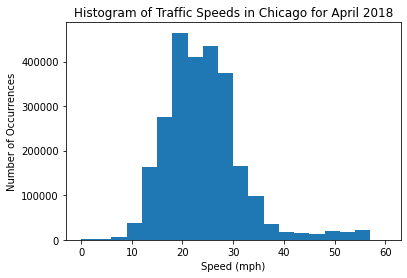

In [12]:
plt.hist(traffic['SPEED'], bins=20, label="test")
plt.xlabel('Speed (mph)')
plt.ylabel('Number of Occurrences')
plt.title('Histogram of Traffic Speeds in Chicago for April 2018')
plt.show() 
#plt.savefig("speedhist2.png") 

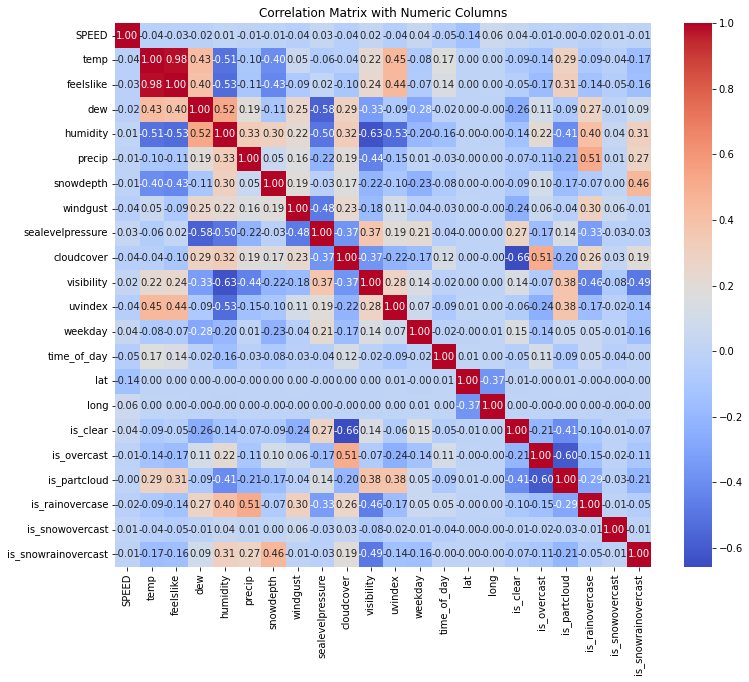

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric columns for correlation (includes the newly created time-based and encoded numeric features)
numeric_df = traffic_standardized.drop(["solarradiation", "solarenergy"],axis=1)

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Numeric Columns')
plt.show()